In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('output/MistralBaseTest.jsonl', 'r') as file:
    mistral_base_results = [json.loads(line) for line in file]
with open('output/MistralMMIQCTest.jsonl', 'r') as file:
    mistral_mmiqc_results = [json.loads(line) for line in file]
with open('output/ttt-random-100-3epochs.jsonl', 'r') as file:
    ttt_500_3ep_r16_random87 = [json.loads(line) for line in file]

ttt_500_3ep_r32 = []
ttt_500_3ep_r64 = []
for batch in range(1, 11):
    ttt_500_3ep_r32_batch_path = f'output/ttt-500-3epochs-{batch}.jsonl'
    ttt_500_3ep_r64_batch_path = f'output/ttt-500-3epochs-{batch}-v2.jsonl'
    if os.path.exists(ttt_500_3ep_r32_batch_path):
        with open(ttt_500_3ep_r32_batch_path, 'r') as file:
            ttt_500_3ep_r32 += [json.loads(line) for line in file]
    if os.path.exists(ttt_500_3ep_r64_batch_path):
        with open(ttt_500_3ep_r64_batch_path, 'r') as file:
            ttt_500_3ep_r64 += [json.loads(line) for line in file]

result_dict_list = []
for result_list in [mistral_base_results, mistral_mmiqc_results, ttt_500_3ep_r32, ttt_500_3ep_r64]:
    result_dict = {}
    for result in result_list:
        result_dict[result['problem']] = result
    result_dict_list.append(result_dict)

mistral_base_results, mistral_mmiqc_results, ttt_500_3ep_r32, ttt_500_3ep_r64 = result_dict_list

print(f"Len of mistral_base_results: {len(mistral_base_results)}, {type(mistral_base_results)}")
print(f"Len of mistral_mmiqc_results: {len(mistral_mmiqc_results)}, {type(mistral_mmiqc_results)}")
print(f"Len of ttt_500_3ep_r32: {len(ttt_500_3ep_r32)},  {type(ttt_500_3ep_r32)}")
print(f"Len of ttt_500_3ep_r64: {len(ttt_500_3ep_r64)}, {type(ttt_500_3ep_r64)}")
print(f"Len of ttt_500_3ep_r16_random87: {len(ttt_500_3ep_r16_random87)}, {type(ttt_500_3ep_r16_random87)}")

Len of mistral_base_results: 5000, <class 'dict'>
Len of mistral_mmiqc_results: 5000, <class 'dict'>
Len of ttt_500_3ep_r32: 3678,  <class 'dict'>
Len of ttt_500_3ep_r64: 3803, <class 'dict'>
Len of ttt_500_3ep_r16_random87: 87, <class 'list'>


In [3]:
all_results_dict = {
    'Mistral Base': mistral_base_results,
    'Mistral MMIQC': mistral_mmiqc_results,
    'Mistral TTT Rank 32': ttt_500_3ep_r32,
    'Mistral TTT Rank 64': ttt_500_3ep_r64
}

In [4]:
common_questions = set()
for results in all_results_dict.values():
    if not common_questions:
        common_questions = set(results.keys())
    else:
        common_questions = common_questions.intersection(set(results.keys()))
print(f"Common questions: {len(common_questions)}")

# Difficulty of questions
question_metadata = {}
test_file = 'datasets/MATH-test.jsonl'
with open(test_file, 'r') as f:
    # has answer, problem and solution fields
    data_points = [json.loads(line) for line in f]

for data_point in data_points:
    meta_data_dict = {}
    meta_data_dict["level"] = data_point["level"]
    meta_data_dict["type"] = data_point["type"]
    question_metadata[data_point["problem"]] = meta_data_dict
question_metadata = {k:v for k, v in question_metadata.items() if k in common_questions}
assert len(question_metadata) == len(common_questions), "Metadata not found for all questions"

Common questions: 3387


In [6]:
# {'correct': True,
#  'answer': '\\frac{\\sqrt{3}}{2}',
#  'model_answer': '$\\frac{\\sqrt{3}}{2}$',
#  'problem': 'Compute $\\sin 120^\\circ$.',
#  'solution': 'Let $P$ be the point on the unit circle that is $120^\\circ$ counterclockwise from $(1,0)$, and let $D$ be the foot of the altitude from $P$ to the $x$-axis, as shown below.\n\n[asy]\n\npair A,C,P,O,D;\n\ndraw((0,-1.2)--(0,1.2),p=black+1.2bp,Arrows(0.15cm));\n\ndraw((-1.2,0)--(1.2,0),p=black+1.2bp,Arrows(0.15cm));\n\nA = (1,0);\n\nO= (0,0);\n\nlabel("$x$",(1.2,0),SE);\n\nlabel("$y$",(0,1.2),NE);\n\nP = rotate(120)*A;\n\nD = foot(P,A,-A);\n\ndraw(O--P--D);\n\ndraw(rightanglemark(O,D,P,2));\n\ndraw(Circle(O,1));\n\nlabel("$O$",O,SE);\n\nlabel("$P$",P,NW);\n\n//label("$A$",A,SE);\n\nlabel("$D$",D,S);\n\n[/asy]\n\nTriangle $POD$ is a 30-60-90 triangle, so $DO = \\frac{1}{2}$ and $DP = \\frac{\\sqrt{3}}{2}$.  Therefore, the coordinates of $P$ are $\\left(-\\frac{1}{2}, \\frac{\\sqrt{3}}{2}\\right)$, so $\\sin 120^\\circ = \\boxed{\\frac{\\sqrt{3}}{2}}$.',
#  'model_solution': 'The answer is: $\\frac{\\sqrt{3}}{2}$.'}

Mistral Base: 143/3387, 4.22%
Mistral MMIQC: 1287/3387, 38.00%
Mistral TTT Rank 32: 590/3387, 17.42%
Mistral TTT Rank 64: 649/3387, 19.16%


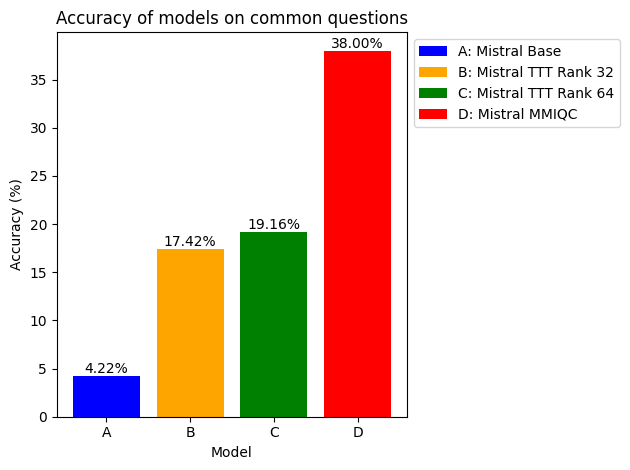

In [25]:
# Accuracy of each model
accuracy_dict = {}
for model_name, results in all_results_dict.items():
    correct = 0
    for question in common_questions:
        if results[question]['correct']:
            correct += 1
    print(f"{model_name}: {correct}/{len(common_questions)}, {correct/len(common_questions)*100:.2f}%")
    accuracy_dict[model_name] = correct/len(common_questions)*100

keys = ["Mistral Base", "Mistral TTT Rank 32", "Mistral TTT Rank 64", "Mistral MMIQC"]
labels = ['A', 'B', 'C', 'D']
colors = ['blue', 'orange', 'green', 'red']

# Plot with legend for model names
fig, ax = plt.subplots()
bar_plot = ax.bar(labels, [accuracy_dict[key] for key in keys], color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
ax.set_title('Accuracy of models on common questions')

# Add percentages on top of each bar
for i, bar in enumerate(bar_plot):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,  # Position above the bar
        f"{height:.2f}%",  # Format with two decimals
        ha='center', va='bottom', fontsize=10
    )

# Add legend for all models
legend_labels = [f"{label}: {key}" for label, key in zip(labels, keys)]
ax.legend(bar_plot, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [8]:
# Accuracy of rank 16 random 100
correct = 0
for question in ttt_500_3ep_r16_random87:
    if question['correct']:
        correct += 1
print(f"Rank 16 random 87: {correct}/{len(ttt_500_3ep_r16_random87)}, {correct/len(ttt_500_3ep_r16_random87)*100:.2f}%")

Rank 16 random 87: 17/87, 19.54%


In [11]:
questions_correct_ft_r64_r32_b = set()
question_correct_ft_r64_r32_not_b = set()
question_correct_ft_r64_not_r32_b = set()
question_correct_ft_not_r64_r32_b = set()
question_correct_not_ft_r64_r32_b = set()

for question in common_questions:
    ft_correct = mistral_mmiqc_results[question]['correct']
    r64_correct = ttt_500_3ep_r64[question]['correct']
    r32_correct = ttt_500_3ep_r32[question]['correct']
    b_correct = mistral_base_results[question]['correct']
    if ft_correct and r64_correct and r32_correct and b_correct:
        questions_correct_ft_r64_r32_b.add(question)
    elif ft_correct and r64_correct and r32_correct and (not b_correct):
        question_correct_ft_r64_r32_not_b.add(question)
    elif ft_correct and r64_correct and (not r32_correct) and (not b_correct):
        question_correct_ft_r64_not_r32_b.add(question)
    elif ft_correct and (not r64_correct) and (not r32_correct) and (not b_correct):
        question_correct_ft_not_r64_r32_b.add(question)
    elif (not ft_correct) and (not r64_correct) and (not r32_correct) and (not b_correct):
        question_correct_not_ft_r64_r32_b.add(question)

question_model_performance_wise = {
    "All models correct": questions_correct_ft_r64_r32_b,
    "Fine-tuned, Rank 64, Rank 32 correct but not base": question_correct_ft_r64_r32_not_b,
    "Fine-tuned, Rank 64 correct but not Rank 32, Base": question_correct_ft_r64_not_r32_b,
    "Fine-tuned correct but not Rank 64, Rank 32, Base": question_correct_ft_not_r64_r32_b,
    "All models incorrect": question_correct_not_ft_r64_r32_b
}

print(f"Number of questions correct for all models: {len(questions_correct_ft_r64_r32_b)}")
print(f"Number of questions correct for ft, r64, r32 but not base: {len(question_correct_ft_r64_r32_not_b)}")
print(f"Number of questions correct for ft, r64 but not r32 and base: {len(question_correct_ft_r64_not_r32_b)}")
print(f"Number of questions correct for ft but not r64, r32 and base: {len(question_correct_ft_not_r64_r32_b)}")
print(f"Number of questions correct for none of the models: {len(question_correct_not_ft_r64_r32_b)}")

Number of questions correct for all models: 60
Number of questions correct for ft, r64, r32 but not base: 240
Number of questions correct for ft, r64 but not r32 and base: 195
Number of questions correct for ft but not r64, r32 and base: 590
Number of questions correct for none of the models: 1857


Level distribution for All models correct: {'Level 3': 7, 'Level 2': 19, 'Level 1': 28, 'Level 4': 6}


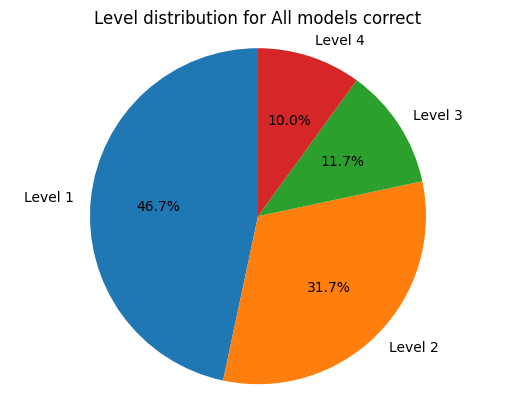

Level distribution for Fine-tuned, Rank 64, Rank 32 correct but not base: {'Level 2': 89, 'Level 3': 52, 'Level 4': 23, 'Level 1': 69, 'Level 5': 7}


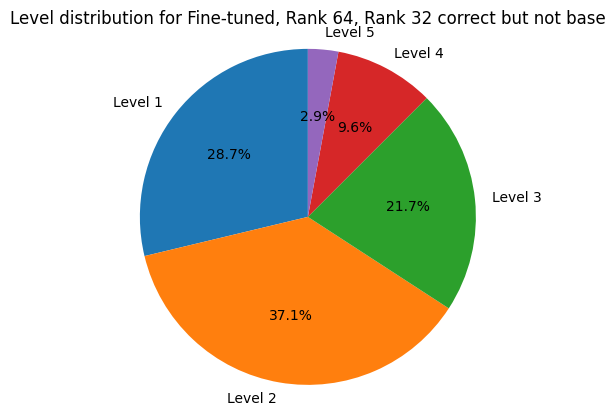

Level distribution for Fine-tuned, Rank 64 correct but not Rank 32, Base: {'Level 5': 17, 'Level 3': 53, 'Level 2': 57, 'Level 1': 38, 'Level 4': 30}


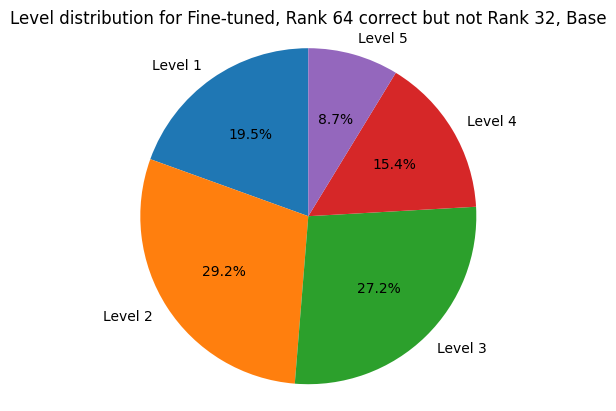

Level distribution for Fine-tuned correct but not Rank 64, Rank 32, Base: {'Level 4': 166, 'Level 1': 47, 'Level 2': 121, 'Level 3': 188, 'Level 5': 68}


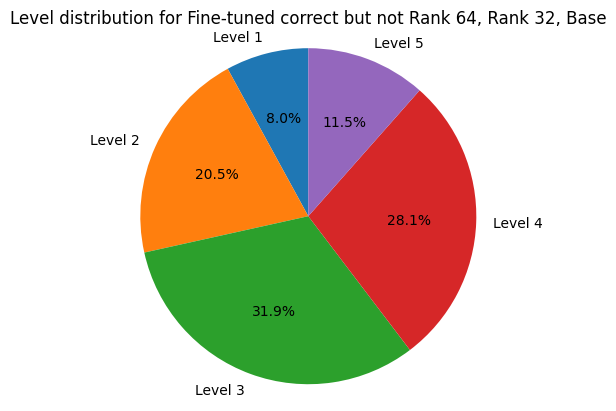

Level distribution for All models incorrect: {'Level 3': 381, 'Level 2': 209, 'Level 5': 728, 'Level 4': 486, 'Level 1': 53}


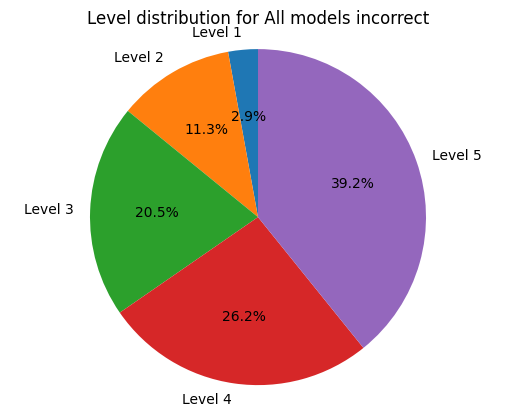

In [12]:
# distibution, pie chart of questions based on difficulty in questions_correct_ft_r64_r32_b, question_correct_ft_r64_r32_not_b, question_correct_ft_r64_not_r32_b, question_correct_ft_not_r64_r32_b, question_correct_not_ft_r64_r32_b

for model_performance_category, questions_set in question_model_performance_wise.items():
    level_distribution = {}
    for question in questions_set:
        level = question_metadata[question]['level']
        if level not in level_distribution:
            level_distribution[level] = 1
        else:
            level_distribution[level] += 1
    print(f"Level distribution for {model_performance_category}: {level_distribution}")
    # Pie chart
    labels = sorted(level_distribution.keys())
    sizes = [level_distribution[label] for label in labels]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.title(f'Level distribution for {model_performance_category}')
    plt.show()

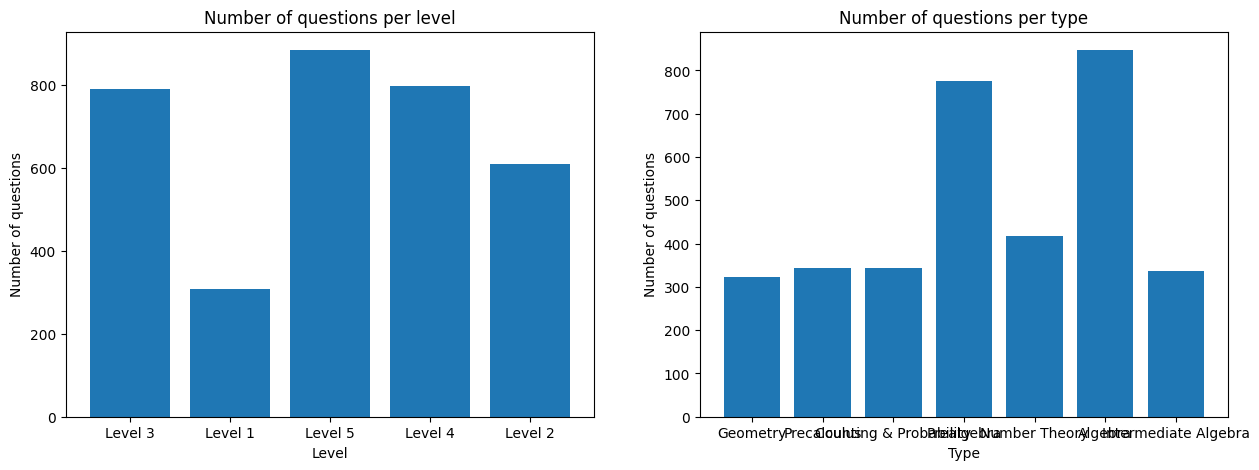

In [75]:
# Bar plot of different types of questions using matplotlib, clean, organized and labeled
level_dict = {}
type_dict = {}
for question in question_metadata:
    level = question_metadata[question]["level"]
    type = question_metadata[question]["type"]
    if level in level_dict:
        level_dict[level] += 1
    else:
        level_dict[level] = 1
    if type in type_dict:
        type_dict[type] += 1
    else:
        type_dict[type] = 1

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(level_dict.keys(), level_dict.values())
ax[0].set_title("Number of questions per level")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Number of questions")
ax[1].bar(type_dict.keys(), type_dict.values())
ax[1].set_title("Number of questions per type")
ax[1].set_xlabel("Type")
ax[1].set_ylabel("Number of questions")
plt.show()

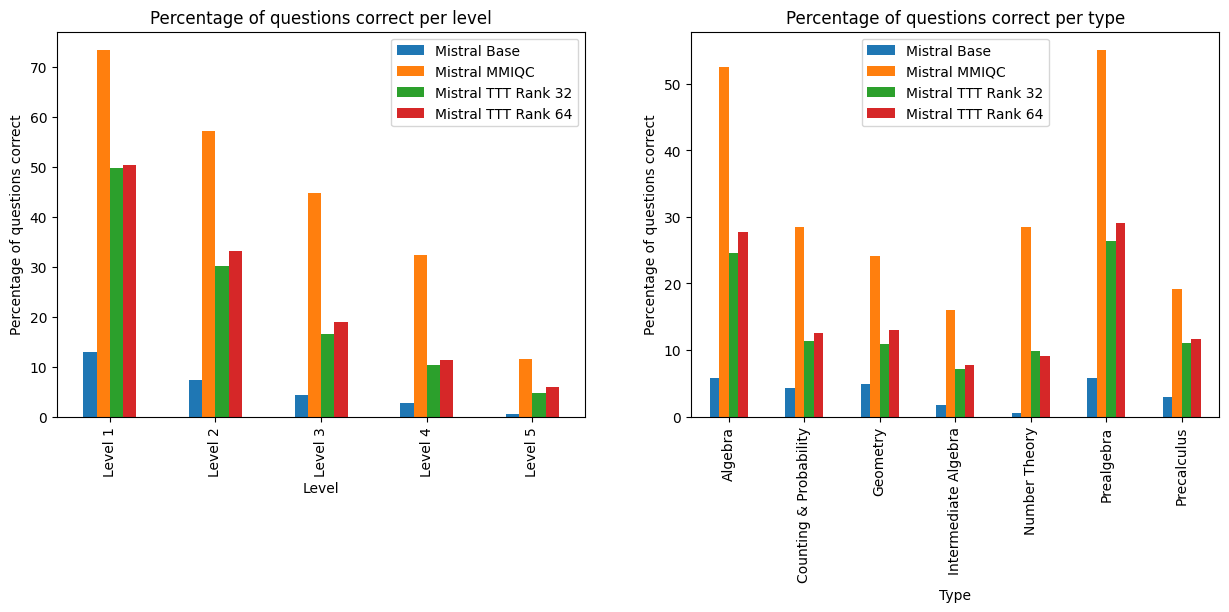

In [71]:
# Plotting accuracy of each model for each type of question
level_accuracy = {}
type_accuracy = {}

for model_name, results in all_results_dict.items():
    level_correct = {}
    type_correct = {}
    for question in common_questions:
        level = question_metadata[question]["level"]
        type = question_metadata[question]["type"]
        if level not in level_correct:
            level_correct[level] = 0
        if type not in type_correct:
            type_correct[type] = 0
        if results[question]["correct"]:
            level_correct[level] += 1
            type_correct[type] += 1
    level_correct = {k: 100*v/len([q for q in common_questions if question_metadata[q]["level"] == k]) for k, v in level_correct.items()}
    type_correct = {k: 100*v/len([q for q in common_questions if question_metadata[q]["type"] == k]) for k, v in type_correct.items()}
    level_accuracy[model_name] = level_correct
    type_accuracy[model_name] = type_correct

level_accuracy_df = pd.DataFrame(level_accuracy).sort_index()
type_accuracy_df = pd.DataFrame(type_accuracy).sort_index()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
level_accuracy_df.plot(kind='bar', ax=ax[0])
ax[0].set_title("Percentage of questions correct per level")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Percentage of questions correct")
type_accuracy_df.plot(kind='bar', ax=ax[1])
ax[1].set_title("Percentage of questions correct per type")
ax[1].set_xlabel("Type")
ax[1].set_ylabel("Percentage of questions correct")
plt.show()



In [72]:
level_accuracy_df

,Mistral Base,Mistral MMIQC,Mistral TTT Rank 32,Mistral TTT Rank 64
Level 1,12.987013,73.376623,49.675325,50.324675
Level 2,7.224959,57.142857,30.049261,33.169130
Level 3,4.303797,44.683544,16.455696,18.860759
Level 4,2.634881,32.371393,10.288582,11.417817
Level 5,0.453001,11.551529,4.756512,5.889015


In [73]:
type_accuracy_df

,Mistral Base,Mistral MMIQC,Mistral TTT Rank 32,Mistral TTT Rank 64
Algebra,5.785124,52.538371,24.557261,27.744982
Counting & Probability,4.360465,28.488372,11.337209,12.500000
Geometry,4.953560,24.148607,10.835913,13.003096
Intermediate Algebra,1.785714,16.071429,7.142857,7.738095
Number Theory,0.478469,28.468900,9.808612,9.090909
Prealgebra,5.806452,55.096774,26.451613,29.032258
Precalculus,2.906977,19.186047,11.046512,11.627907
